In [40]:
%matplotlib notebook
import numpy as np
from numpy.fft import fft2, ifft2, fftshift
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import cm
import scipy
from scipy.ndimage import gaussian_filter1d as gf1d
from scipy.ndimage import gaussian_filter as gf
from scipy.ndimage import uniform_filter as uf
from skimage.transform import downscale_local_mean #For binning

import xarray as xr #package for labeling and adding metadata to multi-dimensional arrays

import sys
sys.path.append("../kai_colloids/PyDDM") #must point to the PyDDM folder
import ddm_analysis_and_fitting as ddm

import tiff_file
import ddm_clean 

import io 
import sys
import csv
import os
import glob #glob is helpful for searching for filenames or directories
import pickle #for saving data

## Image autocorrelation function defined below

In [41]:
def im_corr(im, filter=False, filtersize=80, bin=True, binsize=2):
    '''
    Computes image autocorrelation. 
    Takes as input:
        image: 2D image
        filter: Boolean, if true will filter image with uniform filter
        filtersize: size for uniform filtering
        
    Returns:
        corr_im: the image autocorrelation (this will be same size as image)
        rav_corr: radially averaged image autocorrelation
    '''
    # Crop image
    image = im[:1440, :1440]
        
    if bin:
        image = downscale_local_mean(image, (binsize,binsize), cval=1)
        
    if filter:
        image = image*1.0 - uf(image,filtersize)
    image = 1.0*image-image.mean() #subtract mean
    image = image/image.std() #normalize by standard deviation
    corr_im = abs(fftshift(ifft2(fft2(image)*np.conj(fft2(image)))))/(image.shape[0]*image.shape[1])
    
    #radial average taken
    rav_corr = ddm_clean.newRadav(corr_im)
    
    #return corr_im, rav_corr
    return rav_corr

def filtimage(image, filtersize=80):
    image = image*1.0 - uf(image,filtersize)
    return image

def last_3chars(x):
    return((x.split('\\')[-1])[-7:-4])
#last_3chars(files[0])

###define function to find characteristic correlation lengths of SIA curves 
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

one_over_e = 1.0/np.exp(1) #characteristic decay length 1/e = 0.36787944117144233... 
#print(one_over_e)

In [102]:
###################################################################################
# Specify where the data is and file name for image (or image sequence)           #
###################################################################################

directory = "Z"
exp = "9-5-22_s2_theBigOne"
data_dir = directory+":\\Gregor L\\__Kai Colloids\\"+exp+"\\all tiff files\\20x\\" 
data_dir2 = directory+":\\Gregor L\\__Kai Colloids\\"+exp+"\\reordered tiffs\\" #bottom_row_t01\\
plot_saveto= directory+":\\Gregor L\\__Kai Colloids\\SIA\\Data\\"+exp+"\\"

files = glob.glob(data_dir+"*.tif")
#files = sorted(files, key = last_3chars)
print("found %i files" % len(files))
print(int((len(files))/3))
for i,f in enumerate(files): print (' %i \t %s' % (i, f.split('\\')[-1]))

found 36 files
12
 0 	 20x_row1_g01.tif
 1 	 20x_row1_g02.tif
 2 	 20x_row1_g03.tif
 3 	 20x_row1_g04.tif
 4 	 20x_row1_g05.tif
 5 	 20x_row1_g06.tif
 6 	 20x_row1_g07.tif
 7 	 20x_row1_g08.tif
 8 	 20x_row1_g09.tif
 9 	 20x_row1_g10.tif
 10 	 20x_row1_g11.tif
 11 	 20x_row1_g12.tif
 12 	 20x_row2_g01.tif
 13 	 20x_row2_g02.tif
 14 	 20x_row2_g03.tif
 15 	 20x_row2_g04.tif
 16 	 20x_row2_g05.tif
 17 	 20x_row2_g06.tif
 18 	 20x_row2_g07.tif
 19 	 20x_row2_g08.tif
 20 	 20x_row2_g09.tif
 21 	 20x_row2_g10.tif
 22 	 20x_row2_g11.tif
 23 	 20x_row2_g12.tif
 24 	 20x_row3_g01.tif
 25 	 20x_row3_g02.tif
 26 	 20x_row3_g03.tif
 27 	 20x_row3_g04.tif
 28 	 20x_row3_g05.tif
 29 	 20x_row3_g06.tif
 30 	 20x_row3_g07.tif
 31 	 20x_row3_g08.tif
 32 	 20x_row3_g09.tif
 33 	 20x_row3_g10.tif
 34 	 20x_row3_g11.tif
 35 	 20x_row3_g12.tif


In [103]:
############################################################################################
# specify each condition (frame_names) and the time points of data collection (time_array) #
############################################################################################
frame_names = ["1-3 kA-WT", "WT (no kA)", "EA KaiC", "AE KaiC"]
time_array =  [1.17, 4, 7, 10.33, 13.25, 18.17, 22.08, 25.5, 28.83, 46.08, 49.58, 69.58]
#[0.5, 4.5, 8, 12, 20, 24]
#[0.5, 3.5, 6.5, 9.3, 12.1, 15, 18, 21, 24.5, 27.3, 40.5, 44.3]  
#[0.5, 3.2, 17.75, 20, 22, 24.25, 26, 41.75, 44]
#[0.85, 3.5, 18, 20.4, 22.25, 24.5, 26.2, 41.75, 44.2]
#s1 [1.33, 3.5, 6.5, 9.75, 12.67, 17.5, 21.5, 24.75, 28, 45.5, 48.83, 69.08]
#s2 [1.17, 4, 7, 10.33, 13.25, 18.17, 22.08, 25.5, 28.83, 46.08, 49.58, 69.58]
fig_size = 10,10/1.618
font_size = 16
dpi_num = 800
pixel_size = 0.726 # 4*0.1815 = 0.726

print((files[0]))
eg_im= tiff_file.imread(files[0])
print(eg_im.shape)
frames_per_tiff = int(eg_im.shape[0])
print(frames_per_tiff)
arr_length = int((len(files))/3)
print(arr_length)

Z:\Gregor L\__Kai Colloids\9-5-22_s2_theBigOne\all tiff files\20x\20x_row1_g01.tif


C:\Users\gleech\Documents\GitHub\kai codes\kai_colloids\tiff_file.py:724: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  result = numpy.vstack((p.asarray() if p else nopage)


(5, 1440, 1920)
5
12


###################################################################################################
# makes new tiff files, each new tiff has all consecutive time points for each specific condition #
###################################################################################################
arr_length = int((len(files))/3)

for j in range(frames_per_tiff-1):
    frame_num = str(j+1)

    for i in range(arr_length):    
        row1_im = tiff_file.imread(files[i],key=[j])
        row2_im = tiff_file.imread(files[i+arr_length],key=[j])
        row3_im = tiff_file.imread(files[i+(arr_length*2)],key=[j])
        #print(br_frame1_im.shape[0])
        if i==0:
            row1 = np.zeros((arr_length, row1_im.shape[0], row1_im.shape[1]), dtype=np.uint16)
            row2 = np.zeros((arr_length, row1_im.shape[0], row1_im.shape[1]), dtype=np.uint16)
            row3 = np.zeros((arr_length, row1_im.shape[0], row1_im.shape[1]), dtype=np.uint16)
        row1[i] = row1_im
        row2[i] = row2_im
        row3[i] = row3_im

    tiff_file.imsave(data_dir2 +'20x_row1_'+frame_names[j]+'.tif', row1)
    tiff_file.imsave(data_dir2 +'20x_row2_'+frame_names[j]+'.tif', row2)
    tiff_file.imsave(data_dir2 +'20x_row3_'+frame_names[j]+'.tif', row3)

#####################################################
# **optional** preview of tiff files to be analyzed #
#####################################################
tiff_name = '20x_row1_'+frame_names[0]
tiff_to_show = tiff_file.imread(data_dir2 +tiff_name+'.tif')

fig = plt.figure(figsize=(10,10))    
for i in range (arr_length):
    ax = plt.subplot(4,4,i+1) ##change according to number of frames (6 --> 3,3; 12 --> 4,4)
    ax.set_title("~" + str(time_array[i]) + " hrs", fontsize=10)
    ax.matshow(tiff_to_show[i], cmap = 'gray') #fig.set_cmap('hot') 
    plt.axis('off')
    plt.tight_layout(pad=.25)
fig.savefig(data_dir2+tiff_name+".jpg", dpi=(dpi_num))

In [104]:
im_array = [0.0] * int(len(files))
br_corr_rad_array = [0.0] * int(len(files))
mr_corr_rad_array = [0.0] * int(len(files))
tr_corr_rad_array = [0.0] * int(len(files))

all_xvalues = [0.0] * int(len(files))

<IPython.core.display.Javascript object>


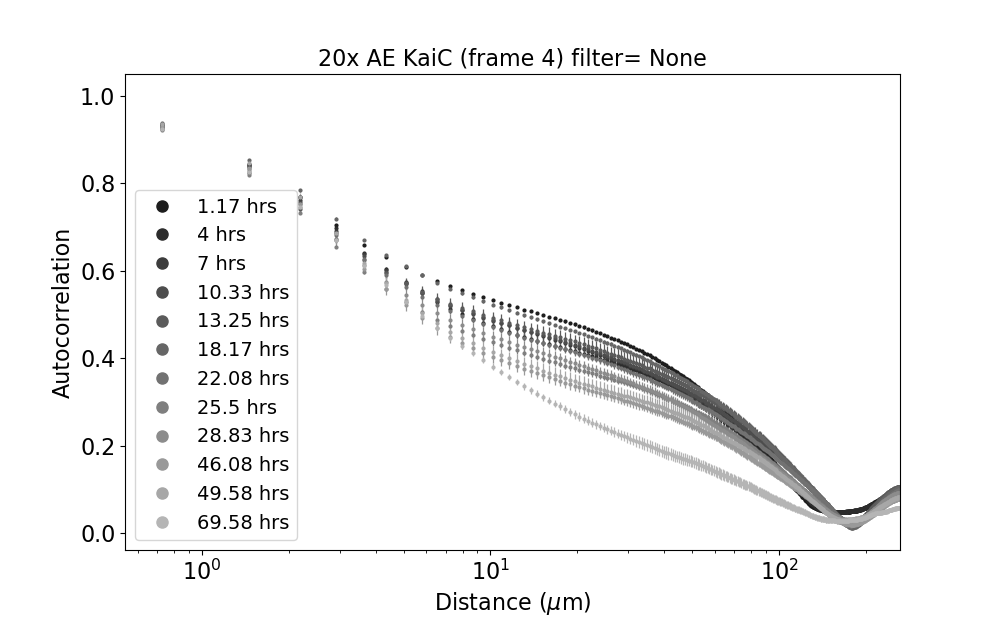

image size: 260.634 x 260.634 um, last x-value= 260.634


<ipython-input-136-dea1f05115ba>:39: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0, all_xvalues[-1] +2) ## (0.091 um/px) * (1440 px) = 131.04 um --> =size of image x-axis in microns


In [136]:
key = 3
cmap = matplotlib.cm.get_cmap('Greys')

t_f = False  #use filter? (True = yes, False = no)
size = 700  #set filter size, recommendation = 200

%matplotlib notebook
fig, ax = plt.subplots(figsize=(fig_size))
ax.tick_params(axis='both', which='major', labelsize=font_size)
markerSize = 4

cmap_num = (arr_length*2) - 2
mean_corr_rad_array  = [0.0] * int(len(files))
std_error_array = [0.0] * int(len(files))

for i in range(arr_length):    
    frame_num = "frame %i" % int(key +1) 
    full_filename = files[i]
    data_file = str(time_array[i]) + " hrs" 
    br_corr_rad_array[i] = im_corr(tiff_file.imread(files[i],key=[key]),filter=t_f,filtersize=size, bin=True, binsize=2)
    mr_corr_rad_array[i] = im_corr(tiff_file.imread(files[i+arr_length],key=[key]),filter=t_f,filtersize=size, bin=True, binsize=2)
    tr_corr_rad_array[i] = im_corr(tiff_file.imread(files[i+(arr_length*2)],key=[key]),filter=t_f,filtersize=size, bin=True, binsize=2)
    all_xvalues = np.arange(len(br_corr_rad_array[0]))*pixel_size
    
    all_ims = np.zeros((3,len(br_corr_rad_array[i])))
    all_ims[0] = br_corr_rad_array[i]
    all_ims[1] = mr_corr_rad_array[i]
    all_ims[2] = tr_corr_rad_array[i]
    mean_corr_rad_array[i] = all_ims.mean(axis=0)
    std_error_array[i] = (all_ims.std(axis=0))/np.sqrt(3)
    
    plt.semilogx(all_xvalues, mean_corr_rad_array[i],'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)),label=data_file)
    ax.errorbar(all_xvalues, mean_corr_rad_array[i], std_error_array[i], fmt = 'none', elinewidth=0.9, c=cmap(0.9-(i/cmap_num))) #, capsize=2)

print("image size: %5.3f x %5.3f um, last x-value= %5.3f" %(all_xvalues[-1], all_xvalues[-1], all_xvalues[-1]))
plt.xlabel("Distance ($\mu$m)",fontsize=font_size)
plt.ylabel("Autocorrelation",fontsize=font_size) 
ax.legend(loc=0, markerscale=4.,fontsize=font_size-2)
plt.xlim(0, all_xvalues[-1] +2) ## (0.091 um/px) * (1440 px) = 131.04 um --> =size of image x-axis in microns
if t_f == False:
    fsize = "None"
else:
    fsize = str(size)
title = '20x ' + frame_names[key] + ' (' + frame_num + ') filter= ' + fsize
plt.title(title, fontsize=font_size)
plt.show()

In [137]:
###save figure 
fig.savefig(plot_saveto+"SIA avg w error for "+title+".jpg", dpi=dpi_num)

<IPython.core.display.Javascript object>


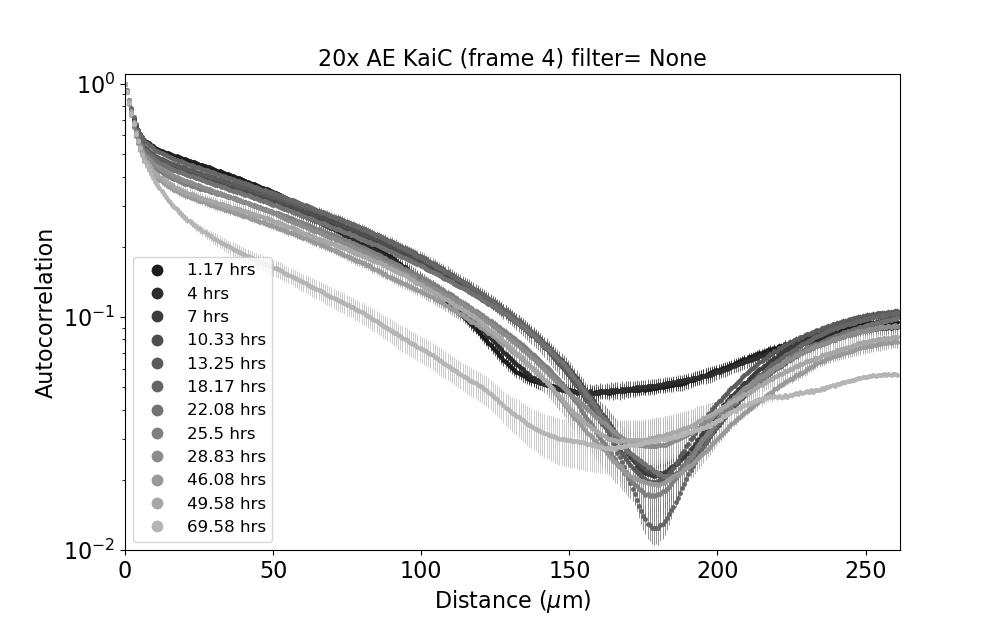

In [138]:
%matplotlib notebook
fig, ax = plt.subplots(figsize=(fig_size))
ax.tick_params(axis='both', which='major', labelsize=font_size)
markerSize = 5

for i in range(arr_length):     
    full_filename = files[i]
    time = str(time_array[i]) + " hrs" 
    y_array =  mean_corr_rad_array[i]
    plt.semilogy(all_xvalues,y_array,'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)),label=time)
    ax.errorbar(all_xvalues,y_array, std_error_array[i], fmt = 'none', elinewidth=0.5, c=cmap(0.9-(i/cmap_num)))

plt.xlabel("Distance ($\mu$m)",fontsize=font_size)
plt.ylabel("Autocorrelation",fontsize=font_size)
ax.legend(loc=0, markerscale=3.,fontsize=font_size-4)
plt.ylim(0.01, 1.1)
plt.xlim(0, all_xvalues[-1] +1) ## (0.091 um/px) * (1440 px) = 131.04 um --> =size of image x-axis in microns

plt.title(title, fontsize=font_size)
###save figure 
fig.savefig(plot_saveto+"SIA semilog-y for "+title+".jpg", dpi=dpi_num)

<IPython.core.display.Javascript object>


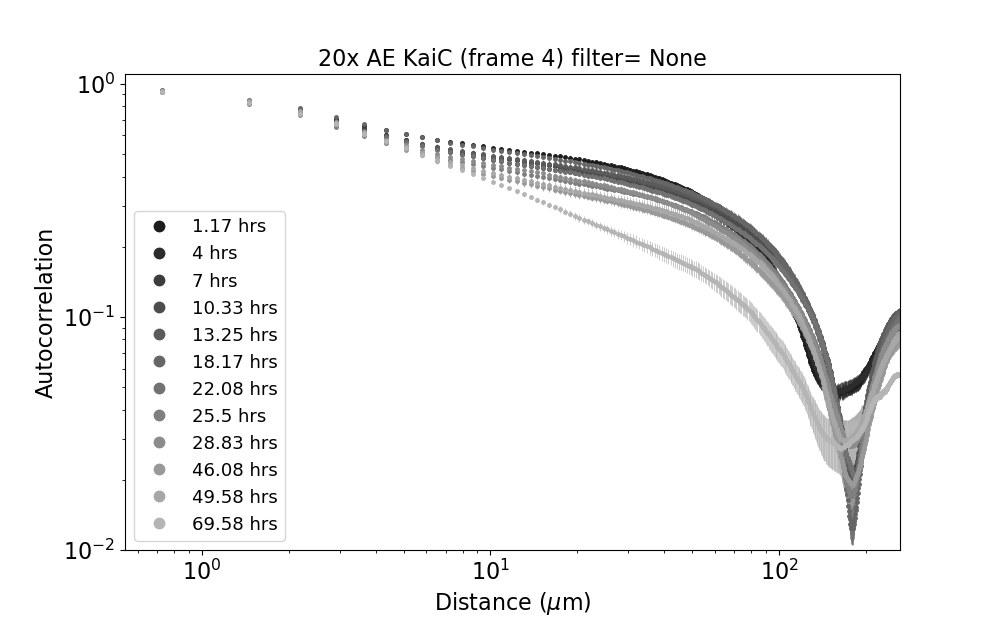

<ipython-input-139-789a4afed38a>:17: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0, all_xvalues[-1] +2)


In [139]:
%matplotlib notebook
fig, ax = plt.subplots(figsize=(fig_size))
ax.tick_params(axis='both', which='major', labelsize=font_size)
markerSize = 5

for i in range(arr_length):     
    full_filename = files[i]
    time = str(time_array[i]) + " hrs" 
    y_array =  mean_corr_rad_array[i]
    plt.loglog(all_xvalues,y_array,'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)),label=time)
    ax.errorbar(all_xvalues,y_array, std_error_array[i], fmt = 'none', elinewidth=0.5, c=cmap(0.9-(i/cmap_num)))

plt.xlabel("Distance ($\mu$m)",fontsize=font_size)
plt.ylabel("Autocorrelation",fontsize=font_size)
ax.legend(loc=0, markerscale=3.,fontsize=(font_size-3))
plt.ylim(0.01, 1.1)
plt.xlim(0, all_xvalues[-1] +2)

plt.title(title, fontsize=font_size)
###save figure 
fig.savefig(plot_saveto+"SIA loglog for "+title+".jpg", dpi=dpi_num)

<IPython.core.display.Javascript object>


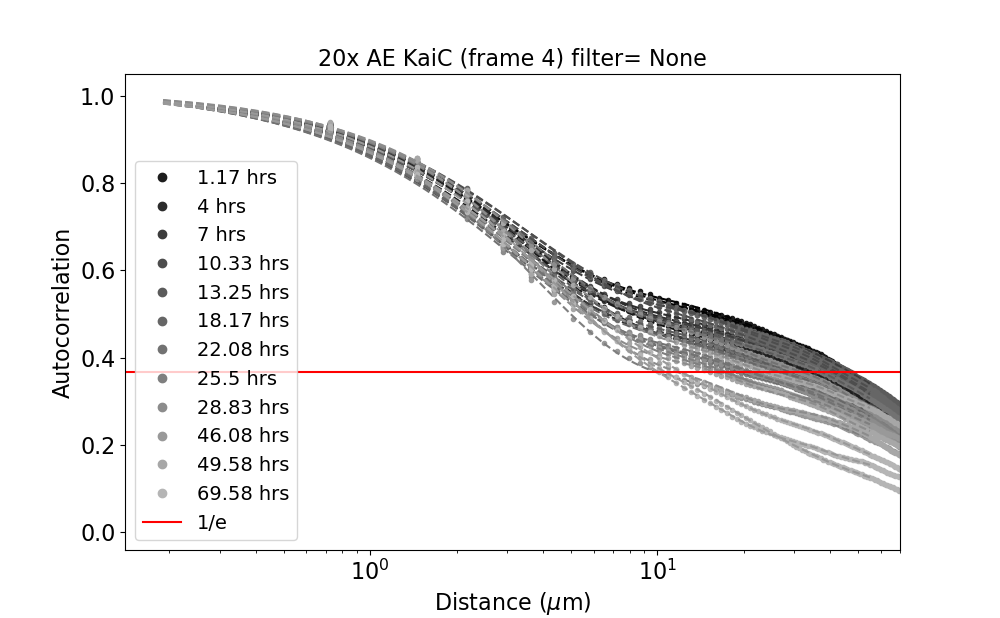

[46.057027027027026, 34.26108108108108, 33.82216216216216, 38.37594594594594, 27.56756756756757, 43.47837837837838, 37.11405405405405, 19.173243243243245, 31.51783783783784, 17.19810810810811, 23.452702702702705, 10.55945945945946]


In [140]:
%matplotlib notebook
#cmap = matplotlib.cm.get_cmap('Blues')
fig, ax = plt.subplots(figsize=(fig_size))
ax.tick_params(axis='both', which='major', labelsize=font_size)
markerSize = 6

frame1_results_dict = {}
frame1_results_dict["time array"] = time_array
br_corr_length_array = [0.0] * arr_length
mr_corr_length_array = [0.0] * arr_length
tr_corr_length_array = [0.0] * arr_length

for i in range(arr_length):     
    full_filename = files[i]
    time = str(time_array[i]) + " hrs" #"time "+(full_filename.split('\\')[-1])[12:-4]
    #y_array =  mean_corr_rad_array[i]
    br_y_array = br_corr_rad_array[i]
    mr_y_array = mr_corr_rad_array[i]
    tr_y_array = tr_corr_rad_array[i]
    plt.semilogx(all_xvalues,br_y_array,'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)),label=time)
    plt.semilogx(all_xvalues,mr_y_array,'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)))
    plt.semilogx(all_xvalues,tr_y_array,'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)))
    
    ###this section does an 18 degree polynomial fit of the SIA data (corr_rad_array) for each frame
    fit_lim = -150 #set to -1 to fit over whole range of SIA, adjust as needed (maybe avoid fitting noisy data at edge of range)
    br_fit = np.poly1d(np.polyfit(all_xvalues[:fit_lim], br_y_array[:fit_lim], 17))
    mr_fit = np.poly1d(np.polyfit(all_xvalues[:fit_lim], mr_y_array[:fit_lim], 17))
    tr_fit = np.poly1d(np.polyfit(all_xvalues[:fit_lim], tr_y_array[:fit_lim], 17))
    x_fit_values = np.linspace(0.19, 55, 1000)
    br_fit_values = br_fit(x_fit_values)
    mr_fit_values = mr_fit(x_fit_values)
    tr_fit_values = tr_fit(x_fit_values)
    plt.semilogx(x_fit_values, br_fit_values,'--',c=cmap(0.99-(i/cmap_num)))
    plt.semilogx(x_fit_values, mr_fit_values,'--',c=cmap(0.99-(i/cmap_num)))
    plt.semilogx(x_fit_values, tr_fit_values,'--',c=cmap(0.99-(i/cmap_num)))
    
    ### find the x-value corresponding to the fit line y-value nearest to 1/e
    br_nearest = find_nearest(br_fit_values, one_over_e)
    br_corr_length = float(x_fit_values[np.where(br_fit_values == br_nearest)])
    
    mr_nearest = find_nearest(mr_fit_values, one_over_e)
    mr_corr_length = float(x_fit_values[np.where(mr_fit_values == mr_nearest)])
    
    tr_nearest = find_nearest(tr_fit_values, one_over_e)
    tr_corr_length = float(x_fit_values[np.where(tr_fit_values == tr_nearest)])
    
    br_corr_length_array[i] = br_corr_length
    mr_corr_length_array[i] = mr_corr_length
    tr_corr_length_array[i] = tr_corr_length
    
    ###saving all data & results to results dictionary 
    frame1_results_dict[time] = {} #creates sub dictionary (within results_dict) for each frame analyzed 
    frame1_results_dict[time]["x vals"] = all_xvalues
    frame1_results_dict[time]["br y vals"] = br_y_array
    frame1_results_dict[time]["mr y vals"] = mr_y_array
    frame1_results_dict[time]["tr y vals"] = tr_y_array
    
    frame1_results_dict[time]["avg y vals"] = mean_corr_rad_array[i]
    frame1_results_dict[time]["avg y error"] = std_error_array[i]
    
    frame1_results_dict[time]["x fit vals"] = x_fit_values
    frame1_results_dict[time]["br fit vals"] = br_fit_values
    frame1_results_dict[time]["mr fit vals"] = mr_fit_values
    frame1_results_dict[time]["tr fit vals"] = tr_fit_values
    
    frame1_results_dict[time]["br corr length"] = br_corr_length
    frame1_results_dict[time]["mr corr length"] = mr_corr_length
    frame1_results_dict[time]["tr corr length"] = tr_corr_length

print(br_corr_length_array)
plt.xlabel("Distance ($\mu$m)",fontsize=font_size)
plt.ylabel("Autocorrelation",fontsize=font_size)
plt.axhline(y=one_over_e, color='r', linestyle='-', label='1/e')
    #####
ax.legend(loc=0, markerscale=2.,fontsize=font_size-2)
plt.axvline(x=127.4, color='pink', linestyle='-', label='ROI size')
#plt.ylim(0.01, 1.1)
plt.xlim(0.14, 70) ## (0.091 um/px) * (1400 px) = 127.4 um --> =size of image x-axis in microns

plt.title(title, fontsize=font_size)

###save dictionary results 
file_to_write = open(plot_saveto+ "SIA results for "+title+".p", "wb")
pickle.dump(frame1_results_dict, file_to_write)

In [141]:
###save figure 
fig.savefig(plot_saveto+"SIA fits for "+title+".jpg", dpi=dpi_num)

<IPython.core.display.Javascript object>


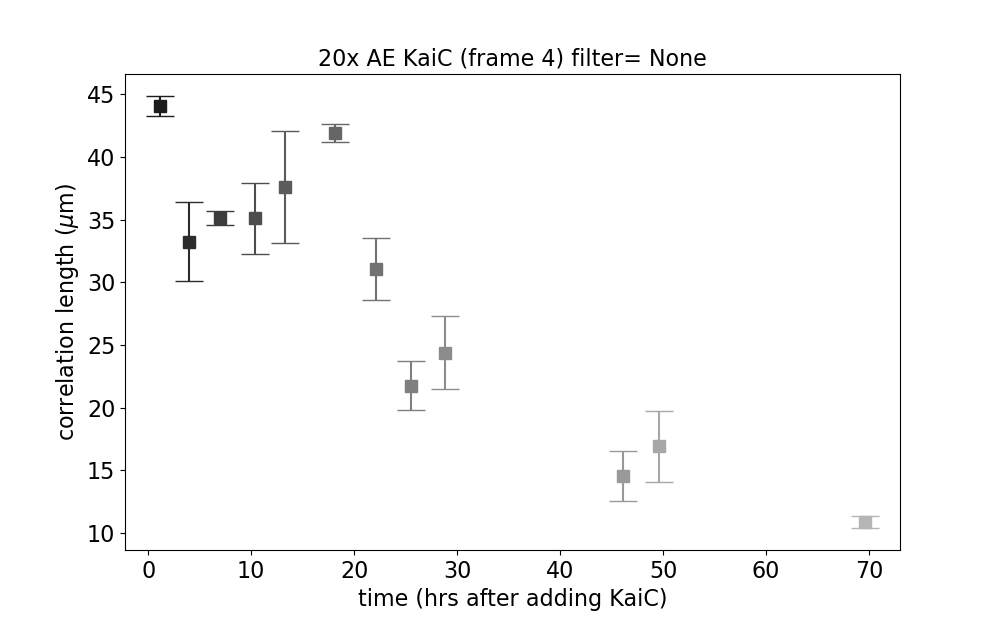

[44.08189189 33.23693694 35.12063063 35.12063063 37.60783784 41.90558559
 31.07891892 21.77018018 24.38540541 14.56459459 16.94207207 10.87036036]


In [142]:
###set figure parameters 
fig, ax = plt.subplots(figsize=(fig_size))
ax.tick_params(axis='both', which='major', labelsize=font_size)
markerSize = 8

#cmap = matplotlib.cm.get_cmap('Blues')

all_corr_lengths = np.zeros((3,len(br_corr_length_array)))
all_corr_lengths[0] = br_corr_length_array
all_corr_lengths[1] = mr_corr_length_array
all_corr_lengths[2] = tr_corr_length_array

mean_corr_length_array = all_corr_lengths.mean(axis=0)
cl_std_dev_array = (all_corr_lengths.std(axis=0))/np.sqrt(3)
print(mean_corr_length_array)

for i in range(int(len(time_array))):
    plt.plot(time_array[i], mean_corr_length_array[i],'s', ms=markerSize, c=cmap(0.9-(i/cmap_num)))
    ax.errorbar(time_array[i], mean_corr_length_array[i], cl_std_dev_array[i], fmt = 'none', ecolor=cmap(0.9-(i/cmap_num)), capsize=10)
num = (int(len(time_array)))/2
#plt.plot(time_array, mean_corr_length_array,'--',ms=(markerSize-3), c=cmap(0.9-(num/cmap_num)))

plt.xlabel("time (hrs after adding KaiC)",fontsize=font_size)
plt.ylabel("correlation length ($\mu$m)",fontsize=font_size)
#plt.ylim(1,24)
#title = frame_names[key] + ' (' + frame_num + ')'
plt.title(title, fontsize=font_size)
#ax.legend(loc=0,fontsize=(font_size))

###save figure 
fig.savefig(plot_saveto+"correlation length vs time for "+title+".jpg", dpi=dpi_num)

<IPython.core.display.Javascript object>


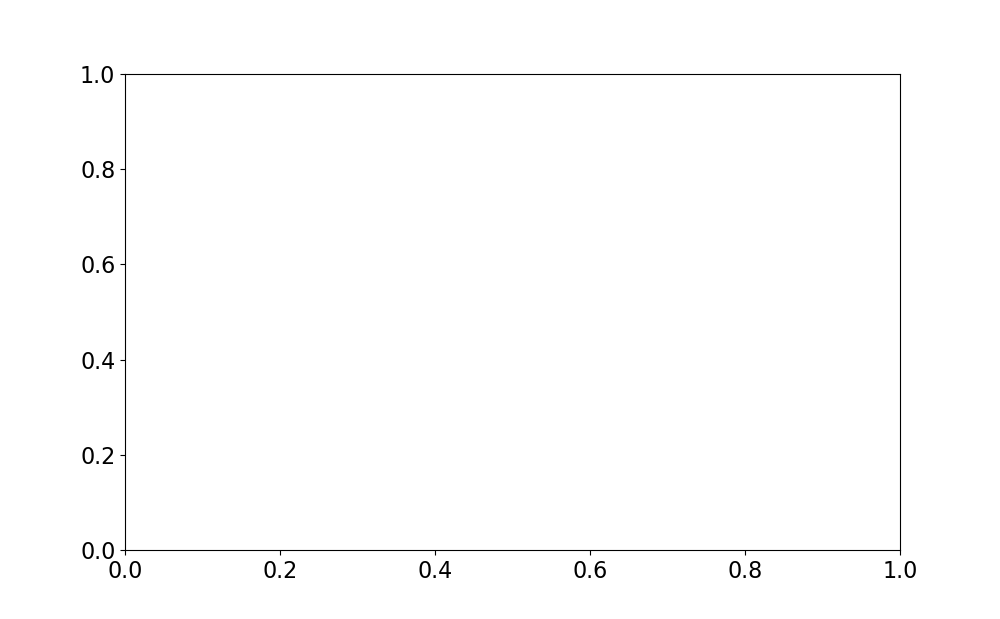

NameError: name 'mean_plat_vals_array' is not defined

In [70]:
###set figure parameters 
fig, ax = plt.subplots(figsize=(fig_size))
ax.tick_params(axis='both', which='major', labelsize=font_size)
markerSize = 8

for i in range(int(len(time_array))):
    plt.plot(time_array[i], mean_plat_vals_array[i],'s', ms=markerSize, c=cmap(0.9-(i/cmap_num)))
    ax.errorbar(time_array[i], mean_plat_vals_array[i], plat_vals_std_error_array[i], fmt = 'none', ecolor=cmap(0.9-(i/cmap_num)), capsize=10)
num = (int(len(time_array)))/2
#plt.plot(time_array, mean_corr_length_array,'--',ms=(markerSize-3), c=cmap(0.9-(num/cmap_num)))

plt.xlabel("time (hrs after adding KaiC)",fontsize=font_size)
plt.ylabel("autocorrelation value",fontsize=font_size)
plt.ylim(0,0.4)
title = frame_names[key] + ' (' + frame_num + ') avg SIA in range 50 to 70 um'
plt.title(title, fontsize=font_size)
#ax.legend(loc=0,fontsize=(font_size))

fig.savefig(plot_saveto+"SIA plateau values for "+title+".jpg", dpi=dpi_num)

In [71]:
csv_data_file = "results- SIA corr lengths for "+title+".csv"
header = []
np.savetxt(plot_saveto+csv_data_file, header, fmt="%s", delimiter=',')
with open(plot_saveto+csv_data_file,'a', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['time (hrs)','br corr length','mr corr length','tr corr length', 
                     'avg corr length', 'std error', 'avg plateau (50-70)', 'plateau std error'])
    for i in range(len(time_array)):
        writer.writerow([time_array[i], br_corr_length_array[i], mr_corr_length_array[i], tr_corr_length_array[i],
                        mean_corr_length_array[i], cl_std_dev_array[i], mean_plat_vals_array[i], plat_vals_std_error_array[i]])
    writer.writerow([''])
f.close()

csv_data_file = "results- SIA raw for "+title+".csv"   
header = []
np.savetxt(plot_saveto+csv_data_file, header, fmt="%s", delimiter=',')
with open(plot_saveto+csv_data_file,'a', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    for j in range(len(time_array)):
        time = str(time_array[j]) + ' hrs'
        writer.writerow([time])
        writer.writerow(['x vals','br y vals','mr y vals','tr y vals', 'avg y vals','avg y error'])
        for i in range(len(frame1_results_dict[time]['x vals'])):
            writer.writerow([frame1_results_dict[time]['x vals'][i], frame1_results_dict[time]['br y vals'][i],
                            frame1_results_dict[time]['mr y vals'][i], frame1_results_dict[time]['tr y vals'][i],
                            frame1_results_dict[time]['avg y vals'][i], frame1_results_dict[time]['avg y error'][i]])
        writer.writerow([''])
        writer.writerow([''])
f.close()

csv_data_file = "results- SIA fits for "+title+".csv"
header = []
np.savetxt(plot_saveto+csv_data_file, header, fmt="%s", delimiter=',')
with open(plot_saveto+csv_data_file,'a', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    for j in range(len(time_array)):
        time = str(time_array[j]) + ' hrs'
        writer.writerow([time])
        writer.writerow(['x fit vals','br fit vals','mr fit vals','tr fit vals'])
        #writer.writerow([frame1_results_dict['0.5 hrs']])
        for i in range(len(frame1_results_dict[time]['x fit vals'])):
            writer.writerow([frame1_results_dict[time]['x fit vals'][i], frame1_results_dict[time]['br fit vals'][i],
                            frame1_results_dict[time]['mr fit vals'][i], frame1_results_dict[time]['tr fit vals'][i]])
        writer.writerow([''])
        writer.writerow([''])
f.close()

NameError: name 'mean_plat_vals_array' is not defined

In [ ]:
#print(results_dict)

In [ ]:
%matplotlib notebook
cmap = matplotlib.cm.get_cmap('Blues')
fig, ax = plt.subplots(figsize=(fig_size))
ax.tick_params(axis='both', which='major', labelsize=font_size)
markerSize = 6

t_f = False  #use filter? (True = yes, False = no)
size = 700  #set filter size, recommendation = 200

key = 1
mean_corr_rad_array  = [0.0] * int(len(files))
std_error_array = [0.0] * int(len(files))

mean_plat_vals_array = []
plat_vals_std_error_array = []

for i in range(arr_length):    
    frame_num = "frame %i" % int(key +1) 
    full_filename = files[i]
    data_file = str(time_array[i]) + " hrs" #"time "+ (full_filename.split('\\')[-1])[12:-4]
    br_corr_rad_array[i] = im_corr(tiff_file.imread(files[i],key=[key]),filter=t_f,filtersize=size, bin=True, binsize=2)
    mr_corr_rad_array[i] = im_corr(tiff_file.imread(files[i+arr_length],key=[key]),filter=t_f,filtersize=size, bin=True, binsize=2)
    tr_corr_rad_array[i] = im_corr(tiff_file.imread(files[i+(arr_length*2)],key=[key]),filter=t_f,filtersize=size, bin=True, binsize=2)
    
    all_ims = np.zeros((3,len(br_corr_rad_array[i])))
    all_ims[0] = br_corr_rad_array[i]
    all_ims[1] = mr_corr_rad_array[i]
    all_ims[2] = tr_corr_rad_array[i]
    
    mean_corr_rad_array[i] = all_ims.mean(axis=0)
    std_error_array[i] = (all_ims.std(axis=0))/np.sqrt(3)
    
    all_plat_vals = np.zeros((3,arr_length))
    all_plat_vals[0] = np.mean(br_corr_rad_array[i][50:70])
    all_plat_vals[1] = np.mean(mr_corr_rad_array[i][50:70])
    all_plat_vals[2] = np.mean(tr_corr_rad_array[i][50:70])
    
    mean_plat_vals_array.append(all_plat_vals.mean(axis=0)[0])
    plat_vals_std_error_array.append((all_plat_vals.std(axis=0)[0])/np.sqrt(3))
    
    xvalues = np.arange(len(br_corr_rad_array[0]))*pixel_size
    all_xvalues = xvalues

    plt.semilogx(xvalues, mean_corr_rad_array[i],'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)),label=data_file)
    
    ax.errorbar(xvalues, mean_corr_rad_array[i], std_error_array[i], fmt = 'none', elinewidth=0.9, c=cmap(0.9-(i/cmap_num)))
    ax.set_xscale("log")
    
plt.xlabel("Distance ($\mu$m)",fontsize=font_size)
plt.ylabel("Autocorrelation",fontsize=font_size)
ax.legend(loc=0, markerscale=2.,fontsize=font_size-2)
    #####
#plt.axvline(x=127.4, color='pink', linestyle='-', label='ROI size')
#plt.ylim(0.01, 1.1)
plt.xlim(0.14, 100) ## (0.091 um/px) * (1400 px) = 127.4 um --> =size of image x-axis in microns
if t_f == False:
    fsize = "None"
else:
    fsize = str(size)
title = frame_names[key] + ' (' + frame_num + ') filter= ' + fsize
    #####
plt.title(title, fontsize=font_size)
#ax.set_xticks([1.0, 10, 40])
#ax.set_xticklabels(['1.0','10','40'], fontsize=12)

In [ ]:
###save figure 
fig.savefig(plot_saveto+"SIA avg w error for "+title+".jpg", dpi=dpi_num)

In [ ]:
%matplotlib notebook
cmap = matplotlib.cm.get_cmap('Blues')
fig, ax = plt.subplots(figsize=(fig_size))
ax.tick_params(axis='both', which='major', labelsize=font_size)
markerSize = 5

for i in range(arr_length):     
    full_filename = files[i]
    time = str(time_array[i]) + " hrs" #"time "+(full_filename.split('\\')[-1])[12:-4]
    y_array =  mean_corr_rad_array[i]
    plt.semilogy(all_xvalues,y_array,'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)),label=time)
    ax.errorbar(all_xvalues,y_array, std_error_array[i], fmt = 'none', elinewidth=0.5, c=cmap(0.9-(i/cmap_num)))

plt.xlabel("Distance ($\mu$m)",fontsize=font_size)
plt.ylabel("Autocorrelation",fontsize=font_size)
#plt.axhline(y=one_over_e, color='r', linestyle='-', label='1/e')
    #####
ax.legend(loc=0, markerscale=2.,fontsize=(font_size-6))
plt.axvline(x=127.4, color='pink', linestyle='-', label='ROI size')
#plt.ylim(0.01, 1.1)
plt.xlim(0, 70) ## (0.091 um/px) * (1400 px) = 127.4 um --> =size of image x-axis in microns
if t_f == False:
    fsize = "None"
else:
    fsize = str(size)
title = frame_names[key] + ' (' + frame_num + ') filter= ' + fsize
plt.title(title, fontsize=font_size)
    #####

In [ ]:
###save figure 
fig.savefig(plot_saveto+"SIA log-y lin-x for "+title+".jpg", dpi=dpi_num)

In [ ]:
%matplotlib notebook
cmap = matplotlib.cm.get_cmap('Blues')
fig, ax = plt.subplots(figsize=(fig_size))
ax.tick_params(axis='both', which='major', labelsize=font_size)
markerSize = 5

for i in range(arr_length):     
    full_filename = files[i]
    time = str(time_array[i]) + " hrs" #"time "+(full_filename.split('\\')[-1])[12:-4]
    y_array =  mean_corr_rad_array[i]
    plt.loglog(all_xvalues,y_array,'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)),label=time)
    ax.errorbar(all_xvalues,y_array, std_error_array[i], fmt = 'none', elinewidth=0.5, c=cmap(0.9-(i/cmap_num)))

plt.xlabel("Distance ($\mu$m)",fontsize=font_size)
plt.ylabel("Autocorrelation",fontsize=font_size)
#plt.axhline(y=one_over_e, color='r', linestyle='-', label='1/e')
    #####
ax.legend(loc=0, markerscale=3.,fontsize=(font_size-2))
plt.axvline(x=127.4, color='pink', linestyle='-', label='ROI size')
#plt.ylim(0.01, 1.1)
plt.xlim(0, 70) ## (0.091 um/px) * (1400 px) = 127.4 um --> =size of image x-axis in microns
if t_f == False:
    fsize = "None"
else:
    fsize = str(size)
title = frame_names[key] + ' (' + frame_num + ') filter= ' + fsize
plt.title(title, fontsize=font_size)
    #####

In [ ]:
###save figure 
fig.savefig(plot_saveto+"SIA loglog for "+title+".jpg", dpi=dpi_num)

In [ ]:
%matplotlib notebook
cmap = matplotlib.cm.get_cmap('Blues')
fig, ax = plt.subplots(figsize=(fig_size))
ax.tick_params(axis='both', which='major', labelsize=font_size)
markerSize = 6

frame2_results_dict = {}
frame2_results_dict["time array"] = time_array
br_corr_length_array = [0.0] * arr_length
mr_corr_length_array = [0.0] * arr_length
tr_corr_length_array = [0.0] * arr_length

for i in range(arr_length):     
    full_filename = files[i]
    time = str(time_array[i]) + " hrs" #"time "+(full_filename.split('\\')[-1])[12:-4]
    #y_array =  mean_corr_rad_array[i]
    br_y_array = br_corr_rad_array[i]
    mr_y_array = mr_corr_rad_array[i]
    tr_y_array = tr_corr_rad_array[i]
    plt.semilogx(all_xvalues,br_y_array,'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)),label=time)
    plt.semilogx(all_xvalues,mr_y_array,'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)))
    plt.semilogx(all_xvalues,tr_y_array,'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)))
    
    ###this section does an 18 degree polynomial fit of the SIA data (corr_rad_array) for each frame
    fit_lim = -50 #set to -1 to fit over whole range of SIA, adjust as needed (maybe avoid fitting noisy data at edge of range)
    br_fit = np.poly1d(np.polyfit(all_xvalues[:fit_lim], br_y_array[:fit_lim], 17))
    mr_fit = np.poly1d(np.polyfit(all_xvalues[:fit_lim], mr_y_array[:fit_lim], 17))
    tr_fit = np.poly1d(np.polyfit(all_xvalues[:fit_lim], tr_y_array[:fit_lim], 17))
    x_fit_values = np.linspace(0.19, 8, 1000)
    br_fit_values = br_fit(x_fit_values)
    mr_fit_values = mr_fit(x_fit_values)
    tr_fit_values = tr_fit(x_fit_values)
    plt.semilogx(x_fit_values, br_fit_values,'--',c=cmap(0.99-(i/cmap_num)))
    plt.semilogx(x_fit_values, mr_fit_values,'--',c=cmap(0.99-(i/cmap_num)))
    plt.semilogx(x_fit_values, tr_fit_values,'--',c=cmap(0.99-(i/cmap_num)))
    
    ### find the x-value corresponding to the fit line y-value nearest to 1/e
    br_nearest = find_nearest(br_fit_values, one_over_e)
    br_corr_length = float(x_fit_values[np.where(br_fit_values == br_nearest)])
    
    mr_nearest = find_nearest(mr_fit_values, one_over_e)
    mr_corr_length = float(x_fit_values[np.where(mr_fit_values == mr_nearest)])
    
    tr_nearest = find_nearest(tr_fit_values, one_over_e)
    tr_corr_length = float(x_fit_values[np.where(tr_fit_values == tr_nearest)])
    
    br_corr_length_array[i] = br_corr_length
    mr_corr_length_array[i] = mr_corr_length
    tr_corr_length_array[i] = tr_corr_length
    
    ###saving all data & results to results dictionary 
    frame2_results_dict[time] = {} #creates sub dictionary (within results_dict) for each frame analyzed 
    frame2_results_dict[time]["x vals"] = all_xvalues
    frame2_results_dict[time]["br y vals"] = br_y_array
    frame2_results_dict[time]["mr y vals"] = mr_y_array
    frame2_results_dict[time]["tr y vals"] = tr_y_array
    
    frame2_results_dict[time]["avg y vals"] = mean_corr_rad_array[i]
    frame2_results_dict[time]["avg y error"] = std_error_array[i]
    
    frame2_results_dict[time]["x fit vals"] = x_fit_values
    frame2_results_dict[time]["br fit vals"] = br_fit_values
    frame2_results_dict[time]["mr fit vals"] = mr_fit_values
    frame2_results_dict[time]["tr fit vals"] = tr_fit_values
    
    frame2_results_dict[time]["br corr length"] = br_corr_length
    frame2_results_dict[time]["mr corr length"] = mr_corr_length
    frame2_results_dict[time]["tr corr length"] = tr_corr_length

print(br_corr_length_array)
plt.xlabel("Distance ($\mu$m)",fontsize=font_size)
plt.ylabel("Autocorrelation",fontsize=font_size)
plt.axhline(y=one_over_e, color='r', linestyle='-', label='1/e')
    #####
ax.legend(loc=0, markerscale=3.,fontsize=(font_size-2))
plt.axvline(x=127.4, color='pink', linestyle='-', label='ROI size')
#plt.ylim(0.01, 1.1)
plt.xlim(0.14, 70) ## (0.091 um/px) * (1400 px) = 127.4 um --> =size of image x-axis in microns
if t_f == False:
    fsize = "None"
else:
    fsize = str(size)
title = frame_names[key] + ' (' + frame_num + ') filter= ' + fsize
plt.title(title, fontsize=font_size)

###save dictionary results 
file_to_write = open(plot_saveto+ "SIA results for "+title+".p", "wb")
pickle.dump(frame1_results_dict, file_to_write)

In [ ]:
###save figure 
fig.savefig(plot_saveto+"SIA fits for "+title+".jpg", dpi=dpi_num)

In [ ]:
###set figure parameters 
fig, ax = plt.subplots(figsize=(fig_size))
ax.tick_params(axis='both', which='major', labelsize=font_size)
markerSize = 8

cmap = matplotlib.cm.get_cmap('Blues')

all_corr_lengths = np.zeros((3,len(br_corr_length_array)))
all_corr_lengths[0] = br_corr_length_array
all_corr_lengths[1] = mr_corr_length_array
all_corr_lengths[2] = tr_corr_length_array

mean_corr_length_array = all_corr_lengths.mean(axis=0)
cl_std_dev_array = (all_corr_lengths.std(axis=0))/np.sqrt(3)

for i in range(int(len(time_array))):
    plt.plot(time_array[i], mean_corr_length_array[i],'s', ms=markerSize, c=cmap(0.9-(i/cmap_num)))
    ax.errorbar(time_array[i], mean_corr_length_array[i], cl_std_dev_array[i], fmt = 'none', ecolor=cmap(0.9-(i/cmap_num)), capsize=10)
num = (int(len(time_array)))/2
#plt.plot(time_array, mean_corr_length_array,'--',ms=(markerSize-3), c=cmap(0.9-(num/cmap_num)))

plt.xlabel("time (hrs after adding KaiC)",fontsize=font_size)
plt.ylabel("correlation length ($\mu$m)",fontsize=font_size)
plt.ylim(1,9)
#title = frame_names[key] + ' (' + frame_num + ')'
plt.title(title, fontsize=font_size)
#ax.legend(loc=0,fontsize=(font_size))

###save figure 
fig.savefig(plot_saveto+"correlation length vs time for "+title+".jpg", dpi=dpi_num)

In [ ]:
###set figure parameters 
fig, ax = plt.subplots(figsize=(fig_size))
ax.tick_params(axis='both', which='major', labelsize=font_size)
markerSize = 8

for i in range(int(len(time_array))):
    plt.plot(time_array[i], mean_plat_vals_array[i],'s', ms=markerSize, c=cmap(0.9-(i/cmap_num)))
    ax.errorbar(time_array[i], mean_plat_vals_array[i], plat_vals_std_error_array[i], fmt = 'none', ecolor=cmap(0.9-(i/cmap_num)), capsize=10)
num = (int(len(time_array)))/2
#plt.plot(time_array, mean_corr_length_array,'--',ms=(markerSize-3), c=cmap(0.9-(num/cmap_num)))

plt.xlabel("time (hrs after adding KaiC)",fontsize=font_size)
plt.ylabel("autocorrelation value",fontsize=font_size)
plt.ylim(0,0.4)
title = frame_names[key] + ' (' + frame_num + ') avg SIA in range 50 to 70 um'
plt.title(title, fontsize=font_size)
#ax.legend(loc=0,fontsize=(font_size))

fig.savefig(plot_saveto+"SIA plateau values for "+title+".jpg", dpi=dpi_num)

In [ ]:
csv_data_file = "results- SIA corr lengths for "+title+".csv"
header = []
np.savetxt(plot_saveto+csv_data_file, header, fmt="%s", delimiter=',')
with open(plot_saveto+csv_data_file,'a', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['time (hrs)','br corr length','mr corr length','tr corr length', 
                     'avg corr length', 'std error', 'avg plateau (50-70)', 'plateau std error'])
    for i in range(len(time_array)):
        writer.writerow([time_array[i], br_corr_length_array[i], mr_corr_length_array[i], tr_corr_length_array[i],
                        mean_corr_length_array[i], cl_std_dev_array[i], mean_plat_vals_array[i], plat_vals_std_error_array[i]])
    writer.writerow([''])
f.close()

csv_data_file = "results- SIA raw for "+title+".csv"   
header = []
np.savetxt(plot_saveto+csv_data_file, header, fmt="%s", delimiter=',')
with open(plot_saveto+csv_data_file,'a', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    for j in range(len(time_array)):
        time = str(time_array[j]) + ' hrs'
        writer.writerow([time])
        writer.writerow(['x vals','br y vals','mr y vals','tr y vals', 'avg y vals','avg y error'])
        for i in range(len(frame2_results_dict[time]['x vals'])):
            writer.writerow([frame2_results_dict[time]['x vals'][i], frame2_results_dict[time]['br y vals'][i],
                            frame2_results_dict[time]['mr y vals'][i], frame2_results_dict[time]['tr y vals'][i],
                            frame2_results_dict[time]['avg y vals'][i], frame2_results_dict[time]['avg y error'][i]])
        writer.writerow([''])
        writer.writerow([''])
f.close()

csv_data_file = "results- SIA fits for "+title+".csv"
header = []
np.savetxt(plot_saveto+csv_data_file, header, fmt="%s", delimiter=',')
with open(plot_saveto+csv_data_file,'a', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    for j in range(len(time_array)):
        time = str(time_array[j]) + ' hrs'
        writer.writerow([time])
        writer.writerow(['x fit vals','br fit vals','mr fit vals','tr fit vals'])
        #writer.writerow([frame1_results_dict['0.5 hrs']])
        for i in range(len(frame2_results_dict[time]['x fit vals'])):
            writer.writerow([frame2_results_dict[time]['x fit vals'][i], frame2_results_dict[time]['br fit vals'][i],
                            frame2_results_dict[time]['mr fit vals'][i], frame2_results_dict[time]['tr fit vals'][i]])
        writer.writerow([''])
        writer.writerow([''])
f.close()

In [ ]:
%matplotlib notebook
cmap = matplotlib.cm.get_cmap('Greens')
fig, ax = plt.subplots(figsize=(fig_size))
ax.tick_params(axis='both', which='major', labelsize=font_size)
markerSize = 6

t_f = False  #use filter? (True = yes, False = no)
size = 700  #set filter size, recommendation = 200

key = 2
mean_corr_rad_array  = [0.0] * int(len(files))
std_error_array = [0.0] * int(len(files))

mean_plat_vals_array = []
plat_vals_std_error_array = []

for i in range(arr_length):    
    frame_num = "frame %i" % int(key +1) 
    full_filename = files[i]
    data_file = str(time_array[i]) + " hrs" #"time "+ (full_filename.split('\\')[-1])[12:-4]
    br_corr_rad_array[i] = im_corr(tiff_file.imread(files[i],key=[key]),filter=t_f,filtersize=size, bin=True, binsize=2)
    mr_corr_rad_array[i] = im_corr(tiff_file.imread(files[i+arr_length],key=[key]),filter=t_f,filtersize=size, bin=True, binsize=2)
    tr_corr_rad_array[i] = im_corr(tiff_file.imread(files[i+(arr_length*2)],key=[key]),filter=t_f,filtersize=size, bin=True, binsize=2)
    
    all_ims = np.zeros((3,len(br_corr_rad_array[i])))
    all_ims[0] = br_corr_rad_array[i]
    all_ims[1] = mr_corr_rad_array[i]
    all_ims[2] = tr_corr_rad_array[i]
    
    mean_corr_rad_array[i] = all_ims.mean(axis=0)
    std_error_array[i] = (all_ims.std(axis=0))/np.sqrt(3)
    
    all_plat_vals = np.zeros((3,arr_length))
    all_plat_vals[0] = np.mean(br_corr_rad_array[i][50:70])
    all_plat_vals[1] = np.mean(mr_corr_rad_array[i][50:70])
    all_plat_vals[2] = np.mean(tr_corr_rad_array[i][50:70])
    
    mean_plat_vals_array.append(all_plat_vals.mean(axis=0)[0])
    plat_vals_std_error_array.append((all_plat_vals.std(axis=0)[0])/np.sqrt(3))
    
    xvalues = np.arange(len(br_corr_rad_array[0]))*pixel_size
    all_xvalues = xvalues

    plt.semilogx(xvalues, mean_corr_rad_array[i],'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)),label=data_file)
    
    ax.errorbar(xvalues, mean_corr_rad_array[i], std_error_array[i], fmt = 'none', elinewidth=0.9, c=cmap(0.9-(i/cmap_num)))
    ax.set_xscale("log")
    
plt.xlabel("Distance ($\mu$m)",fontsize=font_size)
plt.ylabel("Autocorrelation",fontsize=font_size)
ax.legend(loc=0, markerscale=2.,fontsize=font_size-2)
    #####
#plt.axvline(x=127.4, color='pink', linestyle='-', label='ROI size')
#plt.ylim(0.01, 1.1)
plt.xlim(0.14, 100) ## (0.091 um/px) * (1400 px) = 127.4 um --> =size of image x-axis in microns
if t_f == False:
    fsize = "None"
else:
    fsize = str(size)
title = frame_names[key] + ' (' + frame_num + ') filter= ' + fsize
    #####
plt.title(title, fontsize=font_size)
#ax.set_xticks([1.0, 10, 40])
#ax.set_xticklabels(['1.0','10','40'], fontsize=12)

In [ ]:
###save figure 
fig.savefig(plot_saveto+"SIA avg w error for "+title+".jpg", dpi=dpi_num)

In [ ]:
%matplotlib notebook
cmap = matplotlib.cm.get_cmap('Greens')
fig, ax = plt.subplots(figsize=(fig_size))
ax.tick_params(axis='both', which='major', labelsize=font_size)
markerSize = 5

for i in range(arr_length):     
    full_filename = files[i]
    time = str(time_array[i]) + " hrs" #"time "+(full_filename.split('\\')[-1])[12:-4]
    y_array =  mean_corr_rad_array[i]
    plt.semilogy(all_xvalues,y_array,'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)),label=time)
    ax.errorbar(all_xvalues,y_array, std_error_array[i], fmt = 'none', elinewidth=0.5, c=cmap(0.9-(i/cmap_num)))

plt.xlabel("Distance ($\mu$m)",fontsize=font_size)
plt.ylabel("Autocorrelation",fontsize=font_size)
#plt.axhline(y=one_over_e, color='r', linestyle='-', label='1/e')
    #####
ax.legend(loc=0, markerscale=2.,fontsize=(font_size-6))
plt.axvline(x=127.4, color='pink', linestyle='-', label='ROI size')
#plt.ylim(0.01, 1.1)
plt.xlim(0, 70) ## (0.091 um/px) * (1400 px) = 127.4 um --> =size of image x-axis in microns
if t_f == False:
    fsize = "None"
else:
    fsize = str(size)
title = frame_names[key] + ' (' + frame_num + ') filter= ' + fsize
plt.title(title, fontsize=font_size)
    #####

In [ ]:
###save figure 
fig.savefig(plot_saveto+"SIA log-y lin-x for "+title+".jpg", dpi=dpi_num)

In [ ]:
%matplotlib notebook
cmap = matplotlib.cm.get_cmap('Greens')
fig, ax = plt.subplots(figsize=(fig_size))
ax.tick_params(axis='both', which='major', labelsize=font_size)
markerSize = 5

for i in range(arr_length):     
    full_filename = files[i]
    time = str(time_array[i]) + " hrs" #"time "+(full_filename.split('\\')[-1])[12:-4]
    y_array =  mean_corr_rad_array[i]
    plt.loglog(all_xvalues,y_array,'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)),label=time)
    ax.errorbar(all_xvalues,y_array, std_error_array[i], fmt = 'none', elinewidth=0.5, c=cmap(0.9-(i/cmap_num)))

plt.xlabel("Distance ($\mu$m)",fontsize=font_size)
plt.ylabel("Autocorrelation",fontsize=font_size)
#plt.axhline(y=one_over_e, color='r', linestyle='-', label='1/e')
    #####
ax.legend(loc=0, markerscale=3.,fontsize=(font_size-2))
plt.axvline(x=127.4, color='pink', linestyle='-', label='ROI size')
#plt.ylim(0.01, 1.1)
plt.xlim(0, 70) ## (0.091 um/px) * (1400 px) = 127.4 um --> =size of image x-axis in microns
if t_f == False:
    fsize = "None"
else:
    fsize = str(size)
title = frame_names[key] + ' (' + frame_num + ') filter= ' + fsize
plt.title(title, fontsize=font_size)
    #####

In [ ]:
###save figure 
fig.savefig(plot_saveto+"SIA loglog for "+title+".jpg", dpi=dpi_num)

In [ ]:
%matplotlib notebook
cmap = matplotlib.cm.get_cmap('Greens')
fig, ax = plt.subplots(figsize=(fig_size))
ax.tick_params(axis='both', which='major', labelsize=font_size)
markerSize = 6

frame3_results_dict = {}
frame3_results_dict["time array"] = time_array
br_corr_length_array = [0.0] * arr_length
mr_corr_length_array = [0.0] * arr_length
tr_corr_length_array = [0.0] * arr_length

for i in range(arr_length):     
    full_filename = files[i]
    time = str(time_array[i]) + " hrs" #"time "+(full_filename.split('\\')[-1])[12:-4]
    #y_array =  mean_corr_rad_array[i]
    br_y_array = br_corr_rad_array[i]
    mr_y_array = mr_corr_rad_array[i]
    tr_y_array = tr_corr_rad_array[i]
    plt.semilogx(all_xvalues,br_y_array,'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)),label=time)
    plt.semilogx(all_xvalues,mr_y_array,'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)))
    plt.semilogx(all_xvalues,tr_y_array,'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)))
    
    ###this section does an 18 degree polynomial fit of the SIA data (corr_rad_array) for each frame
    fit_lim = -50 #set to -1 to fit over whole range of SIA, adjust as needed (maybe avoid fitting noisy data at edge of range)
    br_fit = np.poly1d(np.polyfit(all_xvalues[:fit_lim], br_y_array[:fit_lim], 17))
    mr_fit = np.poly1d(np.polyfit(all_xvalues[:fit_lim], mr_y_array[:fit_lim], 17))
    tr_fit = np.poly1d(np.polyfit(all_xvalues[:fit_lim], tr_y_array[:fit_lim], 17))
    x_fit_values = np.linspace(0.19, 8, 1000)
    br_fit_values = br_fit(x_fit_values)
    mr_fit_values = mr_fit(x_fit_values)
    tr_fit_values = tr_fit(x_fit_values)
    plt.semilogx(x_fit_values, br_fit_values,'--',c=cmap(0.99-(i/cmap_num)))
    plt.semilogx(x_fit_values, mr_fit_values,'--',c=cmap(0.99-(i/cmap_num)))
    plt.semilogx(x_fit_values, tr_fit_values,'--',c=cmap(0.99-(i/cmap_num)))
    
    ### find the x-value corresponding to the fit line y-value nearest to 1/e
    br_nearest = find_nearest(br_fit_values, one_over_e)
    br_corr_length = float(x_fit_values[np.where(br_fit_values == br_nearest)])
    
    mr_nearest = find_nearest(mr_fit_values, one_over_e)
    mr_corr_length = float(x_fit_values[np.where(mr_fit_values == mr_nearest)])
    
    tr_nearest = find_nearest(tr_fit_values, one_over_e)
    tr_corr_length = float(x_fit_values[np.where(tr_fit_values == tr_nearest)])
    
    br_corr_length_array[i] = br_corr_length
    mr_corr_length_array[i] = mr_corr_length
    tr_corr_length_array[i] = tr_corr_length
    
    ###saving all data & results to results dictionary 
    frame3_results_dict[time] = {} #creates sub dictionary (within results_dict) for each frame analyzed 
    frame3_results_dict[time]["x vals"] = all_xvalues
    frame3_results_dict[time]["br y vals"] = br_y_array
    frame3_results_dict[time]["mr y vals"] = mr_y_array
    frame3_results_dict[time]["tr y vals"] = tr_y_array
    
    frame3_results_dict[time]["avg y vals"] = mean_corr_rad_array[i]
    frame3_results_dict[time]["avg y error"] = std_error_array[i]
    
    frame3_results_dict[time]["x fit vals"] = x_fit_values
    frame3_results_dict[time]["br fit vals"] = br_fit_values
    frame3_results_dict[time]["mr fit vals"] = mr_fit_values
    frame3_results_dict[time]["tr fit vals"] = tr_fit_values
    
    frame3_results_dict[time]["br corr length"] = br_corr_length
    frame3_results_dict[time]["mr corr length"] = mr_corr_length
    frame3_results_dict[time]["tr corr length"] = tr_corr_length

print(br_corr_length_array)
plt.xlabel("Distance ($\mu$m)",fontsize=font_size)
plt.ylabel("Autocorrelation",fontsize=font_size)
plt.axhline(y=one_over_e, color='r', linestyle='-', label='1/e')
    #####
ax.legend(loc=0, markerscale=3.,fontsize=(font_size-2))
plt.axvline(x=127.4, color='pink', linestyle='-', label='ROI size')
#plt.ylim(0.01, 1.1)
plt.xlim(0.14, 70) ## (0.091 um/px) * (1400 px) = 127.4 um --> =size of image x-axis in microns
if t_f == False:
    fsize = "None"
else:
    fsize = str(size)
title = frame_names[key] + ' (' + frame_num + ') filter= ' + fsize
plt.title(title, fontsize=font_size)

###save dictionary results 
file_to_write = open(plot_saveto+ "SIA results for "+title+".p", "wb")
pickle.dump(frame1_results_dict, file_to_write)

In [ ]:
###save figure 
fig.savefig(plot_saveto+"SIA fits for "+title+".jpg", dpi=dpi_num)

In [ ]:
###set figure parameters 
fig, ax = plt.subplots(figsize=(fig_size))
ax.tick_params(axis='both', which='major', labelsize=font_size)
markerSize = 8

cmap = matplotlib.cm.get_cmap('Greens')

all_corr_lengths = np.zeros((3,len(br_corr_length_array)))
all_corr_lengths[0] = br_corr_length_array
all_corr_lengths[1] = mr_corr_length_array
all_corr_lengths[2] = tr_corr_length_array

mean_corr_length_array = all_corr_lengths.mean(axis=0)
cl_std_dev_array = (all_corr_lengths.std(axis=0))/np.sqrt(3)

for i in range(int(len(time_array))):
    plt.plot(time_array[i], mean_corr_length_array[i],'s', ms=markerSize, c=cmap(0.9-(i/cmap_num)))
    ax.errorbar(time_array[i], mean_corr_length_array[i], cl_std_dev_array[i], fmt = 'none', ecolor=cmap(0.9-(i/cmap_num)), capsize=10)
num = (int(len(time_array)))/2
#plt.plot(time_array, mean_corr_length_array,'--',ms=(markerSize-3), c=cmap(0.9-(num/cmap_num)))

plt.xlabel("time (hrs after adding KaiC)",fontsize=font_size)
plt.ylabel("correlation length ($\mu$m)",fontsize=font_size)
plt.ylim(1,9)
#title = frame_names[key] + ' (' + frame_num + ')'
plt.title(title, fontsize=font_size)
#ax.legend(loc=0,fontsize=(font_size))

In [ ]:
###save figure 
fig.savefig(plot_saveto+"correlation length vs time for "+title+".jpg", dpi=dpi_num)

In [ ]:
###set figure parameters 
fig, ax = plt.subplots(figsize=(fig_size))
ax.tick_params(axis='both', which='major', labelsize=font_size)
markerSize = 8

for i in range(int(len(time_array))):
    plt.plot(time_array[i], mean_plat_vals_array[i],'s', ms=markerSize, c=cmap(0.9-(i/cmap_num)))
    ax.errorbar(time_array[i], mean_plat_vals_array[i], plat_vals_std_error_array[i], fmt = 'none', ecolor=cmap(0.9-(i/cmap_num)), capsize=10)
num = (int(len(time_array)))/2
#plt.plot(time_array, mean_corr_length_array,'--',ms=(markerSize-3), c=cmap(0.9-(num/cmap_num)))

plt.xlabel("time (hrs after adding KaiC)",fontsize=font_size)
plt.ylabel("autocorrelation value",fontsize=font_size)
plt.ylim(0,0.4)
title = frame_names[key] + ' (' + frame_num + ') avg SIA in range 50 to 70 um'
plt.title(title, fontsize=font_size)
#ax.legend(loc=0,fontsize=(font_size))

fig.savefig(plot_saveto+"SIA plateau values for "+title+".jpg", dpi=dpi_num)

In [ ]:
csv_data_file = "results- SIA corr lengths for "+title+".csv"
header = []
np.savetxt(plot_saveto+csv_data_file, header, fmt="%s", delimiter=',')
with open(plot_saveto+csv_data_file,'a', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['time (hrs)','br corr length','mr corr length','tr corr length', 
                     'avg corr length', 'std error', 'avg plateau (50-70)', 'plateau std error'])
    for i in range(len(time_array)):
        writer.writerow([time_array[i], br_corr_length_array[i], mr_corr_length_array[i], tr_corr_length_array[i],
                        mean_corr_length_array[i], cl_std_dev_array[i], mean_plat_vals_array[i], plat_vals_std_error_array[i]])
    writer.writerow([''])
f.close()

csv_data_file = "results- SIA raw for "+title+".csv"   
header = []
np.savetxt(plot_saveto+csv_data_file, header, fmt="%s", delimiter=',')
with open(plot_saveto+csv_data_file,'a', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    for j in range(len(time_array)):
        time = str(time_array[j]) + ' hrs'
        writer.writerow([time])
        writer.writerow(['x vals','br y vals','mr y vals','tr y vals', 'avg y vals','avg y error'])
        for i in range(len(frame3_results_dict[time]['x vals'])):
            writer.writerow([frame3_results_dict[time]['x vals'][i], frame3_results_dict[time]['br y vals'][i],
                            frame3_results_dict[time]['mr y vals'][i], frame3_results_dict[time]['tr y vals'][i],
                            frame3_results_dict[time]['avg y vals'][i], frame3_results_dict[time]['avg y error'][i]])
        writer.writerow([''])
        writer.writerow([''])
f.close()

csv_data_file = "results- SIA fits for "+title+".csv"
header = []
np.savetxt(plot_saveto+csv_data_file, header, fmt="%s", delimiter=',')
with open(plot_saveto+csv_data_file,'a', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    for j in range(len(time_array)):
        time = str(time_array[j]) + ' hrs'
        writer.writerow([time])
        writer.writerow(['x fit vals','br fit vals','mr fit vals','tr fit vals'])
        #writer.writerow([frame1_results_dict['0.5 hrs']])
        for i in range(len(frame3_results_dict[time]['x fit vals'])):
            writer.writerow([frame3_results_dict[time]['x fit vals'][i], frame3_results_dict[time]['br fit vals'][i],
                            frame3_results_dict[time]['mr fit vals'][i], frame3_results_dict[time]['tr fit vals'][i]])
        writer.writerow([''])
        writer.writerow([''])
f.close()

In [ ]:
%matplotlib notebook
cmap = matplotlib.cm.get_cmap('Greys')
fig, ax = plt.subplots(figsize=(fig_size))
ax.tick_params(axis='both', which='major', labelsize=font_size)
markerSize = 6

t_f = False  #use filter? (True = yes, False = no)
size = 700  #set filter size, recommendation = 200

key = 3
mean_corr_rad_array  = [0.0] * int(len(files))
std_error_array = [0.0] * int(len(files))

mean_plat_vals_array = []
plat_vals_std_error_array = []

for i in range(arr_length):    
    frame_num = "frame %i" % int(key +1) 
    full_filename = files[i]
    data_file = str(time_array[i]) + " hrs" #"time "+ (full_filename.split('\\')[-1])[12:-4]
    br_corr_rad_array[i] = im_corr(tiff_file.imread(files[i],key=[key]),filter=t_f,filtersize=size, bin=True, binsize=2)
    mr_corr_rad_array[i] = im_corr(tiff_file.imread(files[i+arr_length],key=[key]),filter=t_f,filtersize=size, bin=True, binsize=2)
    tr_corr_rad_array[i] = im_corr(tiff_file.imread(files[i+(arr_length*2)],key=[key]),filter=t_f,filtersize=size, bin=True, binsize=2)
    
    all_ims = np.zeros((3,len(br_corr_rad_array[i])))
    all_ims[0] = br_corr_rad_array[i]
    all_ims[1] = mr_corr_rad_array[i]
    all_ims[2] = tr_corr_rad_array[i]
    
    mean_corr_rad_array[i] = all_ims.mean(axis=0)
    std_error_array[i] = (all_ims.std(axis=0))/np.sqrt(3)
    
    all_plat_vals = np.zeros((3,arr_length))
    all_plat_vals[0] = np.mean(br_corr_rad_array[i][50:70])
    all_plat_vals[1] = np.mean(mr_corr_rad_array[i][50:70])
    all_plat_vals[2] = np.mean(tr_corr_rad_array[i][50:70])
    
    mean_plat_vals_array.append(all_plat_vals.mean(axis=0)[0])
    plat_vals_std_error_array.append((all_plat_vals.std(axis=0)[0])/np.sqrt(3))
    
    xvalues = np.arange(len(br_corr_rad_array[0]))*pixel_size
    all_xvalues = xvalues

    plt.semilogx(xvalues, mean_corr_rad_array[i],'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)),label=data_file)
    
    ax.errorbar(xvalues, mean_corr_rad_array[i], std_error_array[i], fmt = 'none', elinewidth=0.9, c=cmap(0.9-(i/cmap_num)))
    ax.set_xscale("log")
    
plt.xlabel("Distance ($\mu$m)",fontsize=font_size)
plt.ylabel("Autocorrelation",fontsize=font_size)
ax.legend(loc=0, markerscale=2.,fontsize=font_size-2)
    #####
plt.axvline(x=127.4, color='pink', linestyle='-', label='ROI size')
#plt.ylim(0.01, 1.1)
plt.xlim(0.14, 100) ## (0.091 um/px) * (1400 px) = 127.4 um --> =size of image x-axis in microns
if t_f == False:
    fsize = "None"
else:
    fsize = str(size)
title = frame_names[key] + ' (' + frame_num + ') filter= ' + fsize
    #####
plt.title(title, fontsize=font_size)
#ax.set_xticks([1.0, 10, 40])
#ax.set_xticklabels(['1.0','10','40'], fontsize=12)

In [ ]:
###save figure 
fig.savefig(plot_saveto+"SIA avg w error for "+title+".jpg", dpi=dpi_num)

In [ ]:
%matplotlib notebook
cmap = matplotlib.cm.get_cmap('Greys')
fig, ax = plt.subplots(figsize=(fig_size))
ax.tick_params(axis='both', which='major', labelsize=font_size)
markerSize = 5

for i in range(arr_length):     
    full_filename = files[i]
    time = str(time_array[i]) + " hrs" #"time "+(full_filename.split('\\')[-1])[12:-4]
    y_array =  mean_corr_rad_array[i]
    plt.semilogy(all_xvalues,y_array,'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)),label=time)
    ax.errorbar(all_xvalues,y_array, std_error_array[i], fmt = 'none', elinewidth=0.5, c=cmap(0.9-(i/cmap_num)))

plt.xlabel("Distance ($\mu$m)",fontsize=font_size)
plt.ylabel("Autocorrelation",fontsize=font_size)
#plt.axhline(y=one_over_e, color='r', linestyle='-', label='1/e')
    #####
ax.legend(loc=0, markerscale=2.,fontsize=(font_size-6))
plt.axvline(x=127.4, color='pink', linestyle='-', label='ROI size')
#plt.ylim(0.01, 1.1)
plt.xlim(0, 70) ## (0.091 um/px) * (1400 px) = 127.4 um --> =size of image x-axis in microns
if t_f == False:
    fsize = "None"
else:
    fsize = str(size)
title = frame_names[key] + ' (' + frame_num + ') filter= ' + fsize
plt.title(title, fontsize=font_size)
    #####

In [ ]:
###save figure 
fig.savefig(plot_saveto+"SIA log-y lin-x for "+title+".jpg", dpi=dpi_num)

In [ ]:
%matplotlib notebook
cmap = matplotlib.cm.get_cmap('Greys')
fig, ax = plt.subplots(figsize=(fig_size))
ax.tick_params(axis='both', which='major', labelsize=font_size)
markerSize = 5

for i in range(arr_length):     
    full_filename = files[i]
    time = str(time_array[i]) + " hrs" #"time "+(full_filename.split('\\')[-1])[12:-4]
    y_array =  mean_corr_rad_array[i]
    plt.loglog(all_xvalues,y_array,'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)),label=time)
    ax.errorbar(all_xvalues,y_array, std_error_array[i], fmt = 'none', elinewidth=0.5, c=cmap(0.9-(i/cmap_num)))

plt.xlabel("Distance ($\mu$m)",fontsize=font_size)
plt.ylabel("Autocorrelation",fontsize=font_size)
#plt.axhline(y=one_over_e, color='r', linestyle='-', label='1/e')
    #####
ax.legend(loc=0, markerscale=3.,fontsize=(font_size-2))
plt.axvline(x=127.4, color='pink', linestyle='-', label='ROI size')
#plt.ylim(0.01, 1.1)
plt.xlim(0, 70) ## (0.091 um/px) * (1400 px) = 127.4 um --> =size of image x-axis in microns
if t_f == False:
    fsize = "None"
else:
    fsize = str(size)
title = frame_names[key] + ' (' + frame_num + ') filter= ' + fsize
plt.title(title, fontsize=font_size)
    #####

In [ ]:
###save figure 
fig.savefig(plot_saveto+"SIA loglog for "+title+".jpg", dpi=dpi_num)

In [ ]:
%matplotlib notebook
cmap = matplotlib.cm.get_cmap('Greys')
fig, ax = plt.subplots(figsize=(fig_size))
ax.tick_params(axis='both', which='major', labelsize=font_size)
markerSize = 6

frame4_results_dict = {}
frame4_results_dict["time array"] = time_array
br_corr_length_array = [0.0] * arr_length
mr_corr_length_array = [0.0] * arr_length
tr_corr_length_array = [0.0] * arr_length

for i in range(arr_length):     
    full_filename = files[i]
    time = str(time_array[i]) + " hrs" #"time "+(full_filename.split('\\')[-1])[12:-4]
    #y_array =  mean_corr_rad_array[i]
    br_y_array = br_corr_rad_array[i]
    mr_y_array = mr_corr_rad_array[i]
    tr_y_array = tr_corr_rad_array[i]
    plt.semilogx(all_xvalues,br_y_array,'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)),label=time)
    plt.semilogx(all_xvalues,mr_y_array,'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)))
    plt.semilogx(all_xvalues,tr_y_array,'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)))
    
    ###this section does an 18 degree polynomial fit of the SIA data (corr_rad_array) for each frame
    fit_lim = -50 #set to -1 to fit over whole range of SIA, adjust as needed (maybe avoid fitting noisy data at edge of range)
    br_fit = np.poly1d(np.polyfit(all_xvalues[:fit_lim], br_y_array[:fit_lim], 17))
    mr_fit = np.poly1d(np.polyfit(all_xvalues[:fit_lim], mr_y_array[:fit_lim], 17))
    tr_fit = np.poly1d(np.polyfit(all_xvalues[:fit_lim], tr_y_array[:fit_lim], 17))
    x_fit_values = np.linspace(0.19, 8, 1000)
    br_fit_values = br_fit(x_fit_values)
    mr_fit_values = mr_fit(x_fit_values)
    tr_fit_values = tr_fit(x_fit_values)
    plt.semilogx(x_fit_values, br_fit_values,'--',c=cmap(0.99-(i/cmap_num)))
    plt.semilogx(x_fit_values, mr_fit_values,'--',c=cmap(0.99-(i/cmap_num)))
    plt.semilogx(x_fit_values, tr_fit_values,'--',c=cmap(0.99-(i/cmap_num)))
    
    ### find the x-value corresponding to the fit line y-value nearest to 1/e
    br_nearest = find_nearest(br_fit_values, one_over_e)
    br_corr_length = float(x_fit_values[np.where(br_fit_values == br_nearest)])
    
    mr_nearest = find_nearest(mr_fit_values, one_over_e)
    mr_corr_length = float(x_fit_values[np.where(mr_fit_values == mr_nearest)])
    
    tr_nearest = find_nearest(tr_fit_values, one_over_e)
    tr_corr_length = float(x_fit_values[np.where(tr_fit_values == tr_nearest)])
    
    br_corr_length_array[i] = br_corr_length
    mr_corr_length_array[i] = mr_corr_length
    tr_corr_length_array[i] = tr_corr_length
    
    ###saving all data & results to results dictionary 
    frame4_results_dict[time] = {} #creates sub dictionary (within results_dict) for each frame analyzed 
    frame4_results_dict[time]["x vals"] = all_xvalues
    frame4_results_dict[time]["br y vals"] = br_y_array
    frame4_results_dict[time]["mr y vals"] = mr_y_array
    frame4_results_dict[time]["tr y vals"] = tr_y_array
    
    frame4_results_dict[time]["avg y vals"] = mean_corr_rad_array[i]
    frame4_results_dict[time]["avg y error"] = std_error_array[i]
    
    frame4_results_dict[time]["x fit vals"] = x_fit_values
    frame4_results_dict[time]["br fit vals"] = br_fit_values
    frame4_results_dict[time]["mr fit vals"] = mr_fit_values
    frame4_results_dict[time]["tr fit vals"] = tr_fit_values
    
    frame4_results_dict[time]["br corr length"] = br_corr_length
    frame4_results_dict[time]["mr corr length"] = mr_corr_length
    frame4_results_dict[time]["tr corr length"] = tr_corr_length

print(br_corr_length_array)
plt.xlabel("Distance ($\mu$m)",fontsize=font_size)
plt.ylabel("Autocorrelation",fontsize=font_size)
plt.axhline(y=one_over_e, color='r', linestyle='-', label='1/e')
    #####
ax.legend(loc=0, markerscale=3.,fontsize=(font_size-2))
plt.axvline(x=127.4, color='pink', linestyle='-', label='ROI size')
#plt.ylim(0.01, 1.1)
plt.xlim(0.14, 70) ## (0.091 um/px) * (1400 px) = 127.4 um --> =size of image x-axis in microns
if t_f == False:
    fsize = "None"
else:
    fsize = str(size)
title = frame_names[key] + ' (' + frame_num + ') filter= ' + fsize
plt.title(title, fontsize=font_size)

###save dictionary results 
file_to_write = open(plot_saveto+ "SIA results for "+title+".p", "wb")
pickle.dump(frame1_results_dict, file_to_write)

In [ ]:
###save figure 
fig.savefig(plot_saveto+"SIA fits for "+title+".jpg", dpi=dpi_num)

In [ ]:
###set figure parameters 
fig, ax = plt.subplots(figsize=(fig_size))
ax.tick_params(axis='both', which='major', labelsize=font_size)
markerSize = 8

cmap = matplotlib.cm.get_cmap('Greys')

all_corr_lengths = np.zeros((3,len(br_corr_length_array)))
all_corr_lengths[0] = br_corr_length_array
all_corr_lengths[1] = mr_corr_length_array
all_corr_lengths[2] = tr_corr_length_array

mean_corr_length_array = all_corr_lengths.mean(axis=0)
cl_std_dev_array = (all_corr_lengths.std(axis=0))/np.sqrt(3)

for i in range(int(len(time_array))):
    plt.plot(time_array[i], mean_corr_length_array[i],'s', ms=markerSize, c=cmap(0.9-(i/cmap_num)))
    ax.errorbar(time_array[i], mean_corr_length_array[i], cl_std_dev_array[i], fmt = 'none', ecolor=cmap(0.9-(i/cmap_num)), capsize=10)
num = (int(len(time_array)))/2
#plt.plot(time_array, mean_corr_length_array,'--',ms=(markerSize-3), c=cmap(0.9-(num/cmap_num)))

plt.xlabel("time (hrs after adding KaiC)",fontsize=font_size)
plt.ylabel("correlation length ($\mu$m)",fontsize=font_size)
plt.ylim(1,9)
#title = frame_names[key] + ' (' + frame_num + ')'
plt.title(title, fontsize=font_size)
#ax.legend(loc=0,fontsize=(font_size))

In [ ]:
###save figure 
fig.savefig(plot_saveto+"correlation length vs time for "+title+".jpg", dpi=dpi_num)

In [ ]:
###set figure parameters 
fig, ax = plt.subplots(figsize=(fig_size))
ax.tick_params(axis='both', which='major', labelsize=font_size)
markerSize = 8

for i in range(int(len(time_array))):
    plt.plot(time_array[i], mean_plat_vals_array[i],'s', ms=markerSize, c=cmap(0.9-(i/cmap_num)))
    ax.errorbar(time_array[i], mean_plat_vals_array[i], plat_vals_std_error_array[i], fmt = 'none', ecolor=cmap(0.9-(i/cmap_num)), capsize=10)
num = (int(len(time_array)))/2
#plt.plot(time_array, mean_corr_length_array,'--',ms=(markerSize-3), c=cmap(0.9-(num/cmap_num)))

plt.xlabel("time (hrs after adding KaiC)",fontsize=font_size)
plt.ylabel("autocorrelation value",fontsize=font_size)
plt.ylim(0,0.4)
title = frame_names[key] + ' (' + frame_num + ') avg SIA in range 50 to 70 um'
plt.title(title, fontsize=font_size)
#ax.legend(loc=0,fontsize=(font_size))

fig.savefig(plot_saveto+"SIA plateau values for "+title+".jpg", dpi=dpi_num)

In [ ]:
csv_data_file = "results- SIA corr lengths for "+title+".csv"
header = []
np.savetxt(plot_saveto+csv_data_file, header, fmt="%s", delimiter=',')
with open(plot_saveto+csv_data_file,'a', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['time (hrs)','br corr length','mr corr length','tr corr length', 
                     'avg corr length', 'std error', 'avg plateau (50-70)', 'plateau std error'])
    for i in range(len(time_array)):
        writer.writerow([time_array[i], br_corr_length_array[i], mr_corr_length_array[i], tr_corr_length_array[i],
                        mean_corr_length_array[i], cl_std_dev_array[i], mean_plat_vals_array[i], plat_vals_std_error_array[i]])
    writer.writerow([''])
f.close()

csv_data_file = "results- SIA raw for "+title+".csv"   
header = []
np.savetxt(plot_saveto+csv_data_file, header, fmt="%s", delimiter=',')
with open(plot_saveto+csv_data_file,'a', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    for j in range(len(time_array)):
        time = str(time_array[j]) + ' hrs'
        writer.writerow([time])
        writer.writerow(['x vals','br y vals','mr y vals','tr y vals', 'avg y vals','avg y error'])
        for i in range(len(frame4_results_dict[time]['x vals'])):
            writer.writerow([frame4_results_dict[time]['x vals'][i], frame4_results_dict[time]['br y vals'][i],
                            frame4_results_dict[time]['mr y vals'][i], frame4_results_dict[time]['tr y vals'][i],
                            frame4_results_dict[time]['avg y vals'][i], frame4_results_dict[time]['avg y error'][i]])
        writer.writerow([''])
        writer.writerow([''])
f.close()

csv_data_file = "results- SIA fits for "+title+".csv"
header = []
np.savetxt(plot_saveto+csv_data_file, header, fmt="%s", delimiter=',')
with open(plot_saveto+csv_data_file,'a', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    for j in range(len(time_array)):
        time = str(time_array[j]) + ' hrs'
        writer.writerow([time])
        writer.writerow(['x fit vals','br fit vals','mr fit vals','tr fit vals'])
        #writer.writerow([frame1_results_dict['0.5 hrs']])
        for i in range(len(frame4_results_dict[time]['x fit vals'])):
            writer.writerow([frame4_results_dict[time]['x fit vals'][i], frame4_results_dict[time]['br fit vals'][i],
                            frame4_results_dict[time]['mr fit vals'][i], frame4_results_dict[time]['tr fit vals'][i]])
        writer.writerow([''])
        writer.writerow([''])
f.close()